### Для стандартных задачь в DL уже есть готовые решения и библиотеки, которые значительно ускоряют решение задачи и позволяют быстро построить базовое решение с хорошим результатом.
![](https://www.meme-arsenal.com/memes/0eb7d7ba093f7a61409127282e0d4f1b.jpg)

In [1]:
import ktrain
from ktrain import text

INFO:tensorflow:Using local port 18589
INFO:tensorflow:Using local port 20639
INFO:tensorflow:Using local port 15585
INFO:tensorflow:Using local port 24043
INFO:tensorflow:Using local port 16967
INFO:tensorflow:Using local port 17067
INFO:tensorflow:Using local port 18846
INFO:tensorflow:Using local port 15964
INFO:tensorflow:Using local port 19569
INFO:tensorflow:Using local port 18249


Немного погуглив и поспрашивая коллег я нашел множество решений под нашу задачу с уже предобучеными моделями со своими обертками и готовыми пеплайнами.
Например:

* [https://finetune.indico.io](https://finetune.indico.io)
* [https://github.com/huggingface/pytorch-transformers](https://github.com/huggingface/pytorch-transformers)
* [https://github.com/deepset-ai/FARM](https://github.com/deepset-ai/FARM)
* [https://github.com/kaushaltrivedi/fast-bert](https://github.com/kaushaltrivedi/fast-bert)
* [https://github.com/amaiya/ktrain](https://github.com/amaiya/ktrain)

С последней и поработаем. Посмотрим что получилось...



In [2]:
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/train.csv
data/test.csv
data/submission.csv


In [3]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


# SETUP
В setup выносим основные настройки

In [4]:
# MODEL
#BATCH_SIZE  = 32
EPOCH       = 3
VAL_SPLIT   = 0.10  #15%

# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 20000
# Max number of words in each complaint.
MAXLEN    = 100

DATA_PATH = 'data/'
PATH      = 'data/'

# Data
#### TRAIN

In [5]:
train = pd.read_csv(DATA_PATH+'train.csv',)

In [6]:
train.head()

,name,genre,text
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    54214 non-null  object
 1   genre   54214 non-null  object
 2   text    54214 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


Text(0, 0.5, 'Counts')

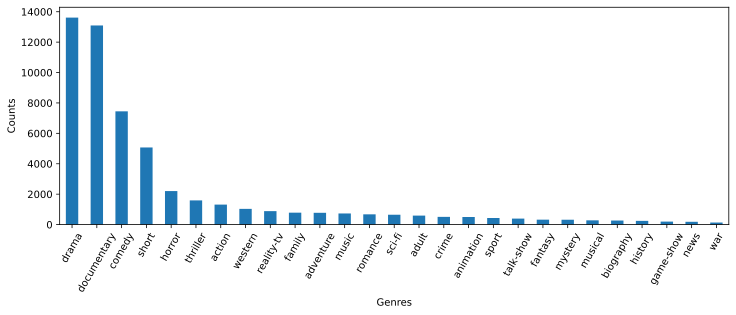

In [8]:
train.genre.value_counts().plot(kind='bar',figsize=(12,4),fontsize=10)
plt.xticks(rotation=60)
plt.xlabel("Genres",fontsize=10)
plt.ylabel("Counts",fontsize=10)

### TEST

In [9]:
test = pd.read_csv(DATA_PATH+'test.csv',)
test.head()

,name,text
0,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,Er nu zhai (1955),Before he was known internationally as a mart...


# Data preprocessing

In [10]:
# Подготовим таргеты
classes =  list(set(train.genre))
#Y = pd.get_dummies(train.genre)
#classes =  Y.columns
train = train[['text', 'genre']]
train = pd.get_dummies(train, prefix='', prefix_sep='', columns=['genre',])
train.to_csv('train_df.csv', index=False)
train.head(3)

,text,action,adult,adventure,animation,biography,comedy,crime,documentary,drama,...,news,reality-tv,romance,sci-fi,short,sport,talk-show,thriller,war,western
0,Listening in to a conversation between his do...,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,A brother and sister with a past incestuous r...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,As the bus empties the students for their fie...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# MODEL ktrain power
Далее Основываясь на примерах:
* [https://github.com/amaiya/ktrain/blob/master/tutorial-04-text-classification.ipynb](https://github.com/amaiya/ktrain/blob/master/tutorial-04-text-classification.ipynb)
* [https://github.com/amaiya/ktrain/blob/master/examples/text/IMDb-BERT.ipynb](https://github.com/amaiya/ktrain/blob/master/examples/text/IMDb-BERT.ipynb)
* [https://github.com/amaiya/ktrain/blob/master/examples/text/toxic_comments-bigru.ipynb](https://github.com/amaiya/ktrain/blob/master/examples/text/toxic_comments-bigru.ipynb)
* и исходниках

строим свое решение

In [11]:
text.print_text_classifiers()

fasttext: a fastText-like model [http://arxiv.org/pdf/1607.01759.pdf]
logreg: logistic regression using a trainable Embedding layer
nbsvm: NBSVM model [http://www.aclweb.org/anthology/P12-2018]
bigru: Bidirectional GRU with pretrained fasttext word vectors [https://fasttext.cc/docs/en/crawl-vectors.html]
standard_gru: simple 2-layer GRU with randomly initialized embeddings
bert: Bidirectional Encoder Representations from Transformers (BERT) [https://arxiv.org/abs/1810.04805]
distilbert: distilled, smaller, and faster BERT from Hugging Face [https://arxiv.org/abs/1910.01108]


В ktrain доступно множество готовых решений под классификацию текста.  
Берем BERT тк сейчас эта одна из лучших языковых моделей: [https://habr.com/ru/post/436878/](https://habr.com/ru/post/436878/)
![](http://www.aitimes.kr/news/photo/201901/13117_13465_1541.jpg)

In [12]:
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(train_df=train, 
                                                                   text_column='text',
                                                                   label_columns=classes,
                                                                   val_pct=VAL_SPLIT, 
                                                                   max_features=MAX_WORDS, 
                                                                   maxlen=MAXLEN,
                                                                   preprocess_mode='bert',
                                                                   ngram_range=1)

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [13]:
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc, )

Is Multi-Label? False
maxlen is 100
done.


In [14]:
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_test, y_test))

In [15]:
learner.autofit(1e-5, EPOCH)



begin training using triangular learning rate policy with max lr of 1e-05...
Epoch 1/3
1525/1525 [==============================] - 429s 275ms/step - loss: 2.2913 - accuracy: 0.3868 - val_loss: 1.2637 - val_accuracy: 0.6155
Epoch 2/3
1525/1525 [==============================] - 392s 257ms/step - loss: 1.1912 - accuracy: 0.6475 - val_loss: 1.1669 - val_accuracy: 0.6396
Epoch 3/3
1525/1525 [==============================] - 393s 258ms/step - loss: 1.0373 - accuracy: 0.6880 - val_loss: 1.1434 - val_accuracy: 0.6475


In [16]:
learner.save_model('model_1')

# Submission

In [17]:
predictor = ktrain.get_predictor(learner.model, preproc)
predictor.save('predictor_1')

In [18]:
predict = predictor.predict(test.text.values)

In [20]:
submission = pd.DataFrame({'id':range(1, len(predict)+1),'genre':predict},columns=['id', 'genre'])
submission.to_csv('submission.csv', index=False)
submission.head()

,id,genre
0,1,short
1,2,comedy
2,3,documentary
3,4,drama
4,5,drama


In [21]:
# на соревнованиях всегда сохраняйте predict_proba, чтоб потом можно было построить ансамбль решений
predict_proba = predictor.predict_proba(test.text.values)
predict_proba = pd.DataFrame(predict_proba, columns=classes)
predict_proba.to_csv('predict_proba.csv', index=False)
predict_proba.head()

,biography,fantasy,adventure,family,news,horror,western,game-show,thriller,talk-show,...,documentary,crime,musical,adult,war,mystery,sport,history,action,animation
0,0.000727,0.004009,0.002265,0.004336,0.000158,0.028085,0.000317,0.000406,0.027077,0.000249,...,0.002299,0.001028,0.000544,0.001872,0.000372,0.004335,0.000606,0.000200,0.001665,0.004754
1,0.001325,0.002362,0.001852,0.213282,0.000661,0.001777,0.000742,0.000964,0.001986,0.000593,...,0.001813,0.000857,0.004017,0.001620,0.001193,0.001062,0.000439,0.000512,0.000954,0.036460
2,0.003070,0.000036,0.000148,0.000201,0.000308,0.000027,0.000062,0.000022,0.000053,0.000115,...,0.981824,0.000146,0.000365,0.000019,0.000321,0.000042,0.000135,0.001041,0.000058,0.000059
3,0.000923,0.000360,0.000640,0.005897,0.000145,0.001900,0.000096,0.000032,0.011580,0.000175,...,0.004900,0.001830,0.000563,0.000094,0.000519,0.000941,0.000145,0.000407,0.003005,0.000258
4,0.029648,0.003135,0.007134,0.018112,0.001952,0.001245,0.001044,0.000170,0.008614,0.001071,...,0.272561,0.006450,0.002474,0.000554,0.017843,0.003100,0.007542,0.024938,0.101403,0.006131


# Итого:
### Вот так С минимальным кодом имеем лучшее решение! 


![](https://memchik.ru/images/mems/5c3d8f1ee1915.jpg)

# Что можно сделать, чтоб улучшить результат:
* Подобрать другие переменные
* Подобрать политику обучения (в либе множество вариантов уже [готовы](https://github.com/amaiya/ktrain/blob/4c9462539fef682572db89d3a2fbaaf2549d2978/tutorial-02-tuning-learning-rates.ipynb))
* Добавить в обучение название фильма
* Попробовать другие модели